In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from collections import defaultdict
from tqdm import tqdm

In [19]:
# %load_ext autoreload
# %autoreload 2

from blackjack_double import BlackjackDoubleEnv
from blackjack_double_count import BlackjackDoubleCountingEnv
# from blackjack_double_counting_split import BlackjackDoubleCountingSplitEnv

## Часть 1.

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


### 1.Стратегия 19-20-21

In [28]:
env = gym.make('Blackjack-v1')

In [5]:
def play_game(env, pi):
    observation = env.reset()
    done = False
    G = 0
    while not done:
        action = pi[s2idx[observation]]
        observation, reward, done, _ = env.step(action)
        G += reward
    return G

def evaluate_pi(env, pi, n=100_000, disable_tqdm=False):
    rewards = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward = play_game(env, pi)
        rewards.append(reward)
    return np.mean(rewards)

In [29]:
A = (0, 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

pi_dummy = [int(state[0] not in {19, 20, 21}) for state, idx in s2idx.items()]

In [17]:
reward_mean = evaluate_pi(env, pi_dummy, n=50_000)
print(f'Выигрыш при стратегии "19-20-21": {reward_mean:.3f}')

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 10614.56it/s]

Выигрыш при стратегии "19-20-21": -0.195


### 2.Метод обучения с подкреплением без модели

In [9]:
def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    s = s2idx[env.reset()]
    done = False
    get_actions_from_env = hasattr(env, 'get_actions')
        
    while not done:
        pi = get_pi_by_Q(Q)
        a = pi[s] if random.random() < (1 - epsilon) else random.choice(env.get_actions() if get_actions_from_env else A)
        observation, r_new, done, _ = env.step(a)
        s_new = s2idx[observation]
        Q[s, a] = Q[s, a] + alpha * (r_new + gamma * max(Q[s_new]) - Q[s, a])
        s = s_new
    return Q

def Q_learning(env, A, Q, episodes=100_000, alpha=0.009, epsilon=0.85, gamma=1, disable_tqdm=False):
    for _ in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        
    return Q

def get_pi_by_Q(Q):
    return np.argmax(Q, axis=1)

In [30]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.02, epsilon=0.1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=50_000)
print(f'Выигрыш при стратегии с  Q-обучением: {reward_mean:.3f}')

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 13160.09it/s]

Выигрыш при стратегии с  Q-обучением: -0.142


### 3. Подбор гипер-параметров и построение графика

In [28]:
for epsilon in np.linspace(0.05, 1, 10):
    print(epsilon)

0.05
0.15555555555555556
0.2611111111111111
0.36666666666666664
0.4722222222222222
0.5777777777777778
0.6833333333333333
0.788888888888889
0.8944444444444445
1.0


In [29]:
for epsilon in np.linspace(0.05, 1, 10):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=10_000, alpha=0.00005, epsilon=epsilon, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.08937
epsilon=0.15556, reward=-0.08244
epsilon=0.26111, reward=-0.08173
epsilon=0.36667, reward=-0.07530
epsilon=0.47222, reward=-0.07637
epsilon=0.57778, reward=-0.07401
epsilon=0.68333, reward=-0.07004
epsilon=0.78889, reward=-0.06889
epsilon=0.89444, reward=-0.06808
epsilon=1.00000, reward=-0.06653


In [30]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005]:
    tries = 5
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=10_000, alpha=alpha, epsilon=0.95, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=-0.06376
alpha=0.00002, reward=-0.06877
alpha=0.00005, reward=-0.06459
alpha=0.00010, reward=-0.06473
alpha=0.00020, reward=-0.06616
alpha=0.00050, reward=-0.06455


In [32]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=10_000, alpha=0.00001, epsilon=1)
pi = get_pi_by_Q(Q)

reward_mean = evaluate_pi(env, pi, n=50_000)
print(f'Выигрыш при стратегии с  Q-обучением: {reward_mean:.5f}')

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9895.33it/s]

Выигрыш при стратегии с  Q-обучением: -0.06166


In [25]:
def plot_learinig(env, A, alpha, epsilon, episodes=10000, n_experiments=20, n_eval=100):

    Q_arr = [np.zeros((len(S), len(A)))] * n_experiments
    pi_arr = [get_pi_by_Q(Q) for Q in Q_arr]
    results = []

    episode_results = []
    episode_nums = []

    for episode in tqdm(range(episodes)):
        experiments_result = []
        for i in range(n_experiments):
            Q_arr[i] = Q_learning_episode(env, Q_arr[i], A, alpha=alpha, epsilon=epsilon)
            pi_arr[i] = get_pi_by_Q(Q_arr[i])
            experiments_result.append(evaluate_pi(env, pi_arr[i], n=n_eval, disable_tqdm=True))

        episode_results.append(np.mean(experiments_result))
        episode_nums.append(episode)

    plt.figure(figsize=(16, 8))
    plt.plot(episode_nums, episode_results, linewidth=1)
    plt.xlabel('Число эпизодов обучения')
    plt.ylabel('Награда')
    print(f'Награда каждого эпизода усреднена по {n_experiments} экспериментам и посчитана на {n_eval} раздачах. Всего {episodes} эпизодов')
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [23:38<00:00,  7.05it/s]


Награда каждого эпизода усреднена по 20 экспериментам и посчитана на 100 раздачах. Всего 10000 эпизодов


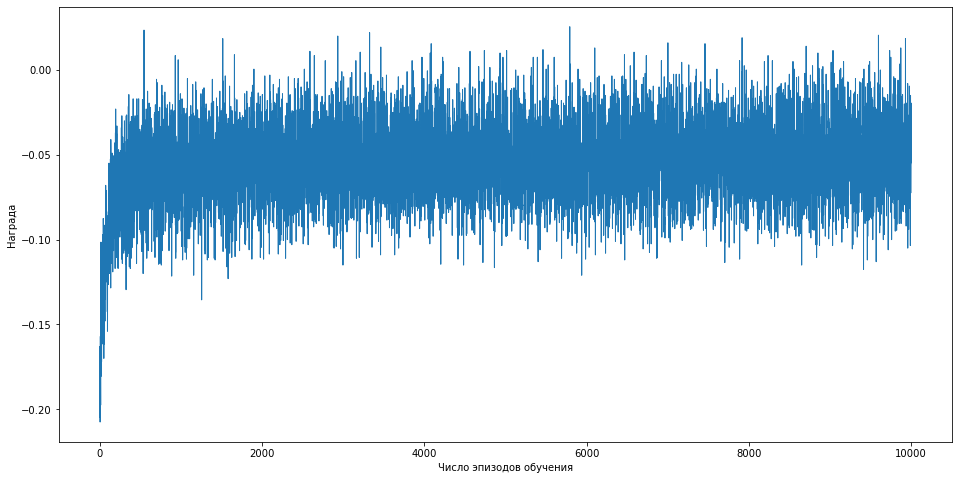

In [31]:
plot_learinig(env, A, alpha=0.00001, epsilon=1)

 Подбор гиперпараметров позволил увеличить выигрыш, но стратегия пока проигрышная

## Часть 2.

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [33]:
env = BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)

In [7]:
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [18]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00001, epsilon=1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)
    
print(f'Выигрыш при стратегии с  Q-обучением c действием double: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 15539.83it/s]

Выигрыш при стратегии с  Q-обучением c действием double: -0.06701


In [ ]:
# подбор параметров по частям

In [11]:
for epsilon in np.linspace(0.05, 1, 10):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=10_000, alpha=0.00005, epsilon=epsilon, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.10929
epsilon=0.15556, reward=-0.09061
epsilon=0.26111, reward=-0.08844
epsilon=0.36667, reward=-0.08427
epsilon=0.47222, reward=-0.08607
epsilon=0.57778, reward=-0.07438
epsilon=0.68333, reward=-0.06786
epsilon=0.78889, reward=-0.06277
epsilon=0.89444, reward=-0.06624
epsilon=1.00000, reward=-0.07222


In [12]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005]:
    tries = 5
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = Q_learning(env, A, Q, episodes=10_000, alpha=alpha, epsilon=0.95, disable_tqdm=True)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi, disable_tqdm=True)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=-0.06721
alpha=0.00002, reward=-0.07315
alpha=0.00005, reward=-0.06753
alpha=0.00010, reward=-0.06236
alpha=0.00020, reward=-0.07345
alpha=0.00050, reward=-0.05973


In [16]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=100_000, alpha=0.00050, epsilon=0.78889)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)
    
print(f'Выигрыш при стратегии с  Q-обучением c действием double: {reward_mean:.5f}')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 14086.48it/s]

Выигрыш при стратегии с  Q-обучением c действием double: -0.03522


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [18:57<00:00,  8.79it/s]


Награда каждого эпизода усреднена по 20 экспериментам и посчитана на 100 раздачах. Всего 10000 эпизодов


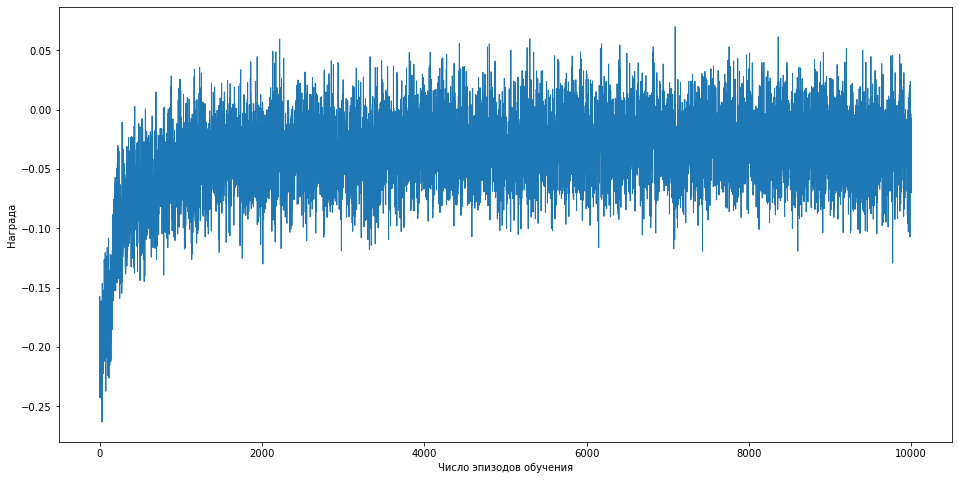

In [34]:
plot_learinig(env, A, alpha=0.00050, epsilon=0.78889)

In [ ]:
# график

Стратегия более выигрышная, но пока все еще в минусе

## Часть 3. 

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
- Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



In [20]:
env = BlackjackDoubleCountingEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [24]:
Q = np.zeros((len(S), len(A)))
Q = Q_learning(env, A, Q, episodes=300_000, alpha=0.0002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=300_000)

print(f'Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

100%|████████████████████████████████████████████████████████████████████████| 300000/300000 [00:31<00:00, 9466.24it/s]

Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : 0.00953


In [27]:
env

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [24:37<00:00,  6.77it/s]


Награда каждого эпизода усреднена по 20 экспериментам и посчитана на 100 раздачах. Всего 10000 эпизодов


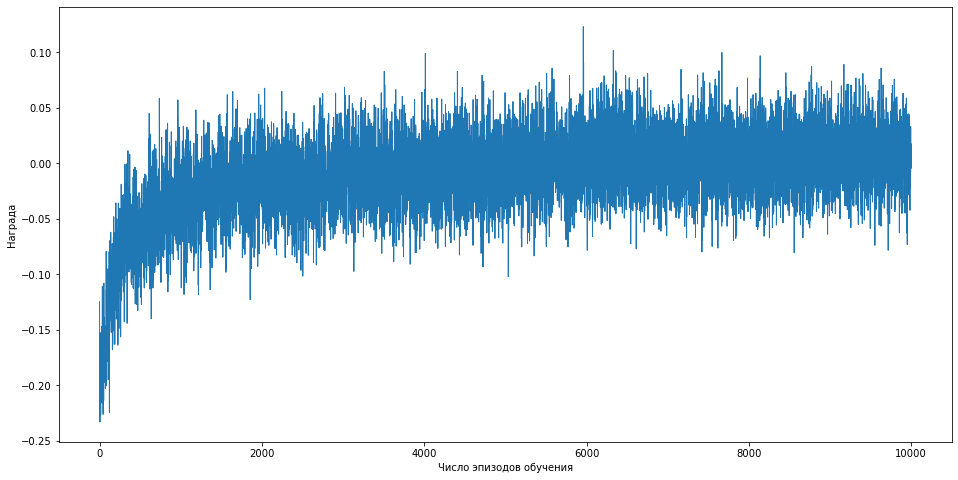

In [26]:
plot_learinig(env, A, alpha=0.00001, epsilon=1)

Эта стратегия позволяет переиграть казино.